In [1]:
install.packages("did", repos = "https://cloud.r-project.org")

Installing package into 'C:/Users/pguer/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'did' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\pguer\AppData\Local\Temp\RtmpEpY0Kl\downloaded_packages

The downloaded binary packages are in
	C:\Users\pguer\AppData\Local\Temp\RtmpEpY0Kl\downloaded_packages


In [2]:
# Librerías y configuración
library(tidyverse)
library(data.table)
library(ggplot2)

# Tema y paleta global
theme_set(theme_minimal() + theme(
  plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
  plot.subtitle = element_text(size = 11, hjust = 0.5, color = "gray40"),
  axis.title = element_text(size = 11, face = "bold"),
  panel.grid.major.x = element_blank(),
  panel.grid.minor = element_blank()
))

out_dir <- "../output"

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Adjuntando el paquete: 'data.table'


The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are maske

In [3]:
# =============================================================================
# SETUP: Load Required Libraries
# =============================================================================
library(tidyverse)
library(did)
library(fixest)
library(broom)
library(scales)

theme_set(theme_minimal(base_size = 14))
cat("Libraries loaded successfully!\n")


Adjuntando el paquete: 'scales'


The following object is masked from 'package:fixest':

    pvalue


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor


The following object is masked from 'package:fixest':

    pvalue


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




Libraries loaded successfully!


In [4]:
# =============================================================================
# DATA LOADING
# =============================================================================
url <- "https://raw.githubusercontent.com/LOST-STATS/LOST-STATS.github.io/master/Model_Estimation/Data/Event_Study_DiD/bacon_example.csv"
df <- read.csv(url)

# Normalize column names
if ('_nfd' %in% names(df)) df <- df %>% rename(X_nfd = `_nfd`)

cat("Dataset loaded:", nrow(df), "rows x", ncol(df), "columns\n")
cat("\nTreatment cohorts (X_nfd = 0 means never-treated):\n")
print(table(df$X_nfd))

Dataset loaded: 1617 rows x 10 columns

Treatment cohorts (X_nfd = 0 means never-treated):

1969 1970 1971 1972 1973 1974 1975 1976 1977 1980 1984 1985 
  66   66  231   99  330   99   66   33   99   33   33   33 

Treatment cohorts (X_nfd = 0 means never-treated):

1969 1970 1971 1972 1973 1974 1975 1976 1977 1980 1984 1985 
  66   66  231   99  330   99   66   33   99   33   33   33 


---

## Part a) Estimate ATT(g,t) using CSDiD

### The Callaway-Sant'Anna Estimator

The CSDiD estimator computes **group-time average treatment effects**:

$$ATT(g,t) = E[Y_t(1) - Y_t(0) \mid G_g = 1]$$

Where:
- $g$ = treatment cohort (first treatment period)
- $t$ = calendar time period
- $G_g = 1$ indicates units first treated in period $g$

### Control Group Choice

We use `control_group = "notyettreated"` which includes:
1. **Never-treated units**: Units that never receive treatment (X_nfd = 0)
2. **Not-yet-treated units**: Units treated in the future but not yet at time $t$

**Why this choice?** Avoids "forbidden comparisons" using already-treated units as controls.

In [5]:
# =============================================================================
# ESTIMATE ATT(g,t) USING CALLAWAY-SANT'ANNA
# =============================================================================
att_gt_obj <- tryCatch({
  att_gt(
    yname = "asmrs",          # Outcome variable
    tname = "year",           # Time variable
    idname = "stfips",        # Unit identifier
    gname = "X_nfd",          # Group (first treatment period, 0 = never-treated)
    xformla = ~ pcinc + asmrh + cases,  # Control variables
    data = df,
    control_group = "notyettreated",    # Use not-yet-treated as controls
    est_method = "dr",        # Doubly robust estimation
    anticipation = 0,         # No anticipation
    base_period = "varying"   # Varying base period
  )
}, error = function(e) {
  cat("Note: Estimation with covariates failed. Falling back to no covariates.\n")
  att_gt(
    yname = "asmrs", tname = "year", idname = "stfips", gname = "X_nfd",
    xformla = ~ 1, data = df, control_group = "notyettreated",
    est_method = "dr", anticipation = 0, base_period = "varying"
  )
})

cat("========================================================================\n")
cat("ATT(g,t) ESTIMATION COMPLETE\n")
cat("Control Group: Not-yet-treated (never-treated + future-treated)\n")
cat("Estimation Method: Doubly Robust\n")
cat("========================================================================\n")
summary(att_gt_obj)

Warning message in pre_process_did(yname = yname, tname = tname, idname = idname, :
"dropped 429 rows from original data due to missing data"
Warning message in pre_process_did(yname = yname, tname = tname, idname = idname, :
"Be aware that there are some small groups in your dataset.
  Check groups: 1969,1970,1971,1972,1974,1975,1976,1977,1980,1984,1985."
Warning message in pre_process_did(yname = yname, tname = tname, idname = idname, :
"Be aware that there are some small groups in your dataset.
  Check groups: 1969,1970,1971,1972,1974,1975,1976,1977,1980,1984,1985."
Warning message in compute.att_gt(dp):
"overlap condition violated for 1969 in time period 1977"
Warning message in compute.att_gt(dp):
"Not enough control units for group 1969 in time period 1977 to run specified regression"
Warning message in compute.att_gt(dp):
"overlap condition violated for 1969 in time period 1978"
Warning message in compute.att_gt(dp):
"Not enough control units for group 1969 in time period 1978 t

ATT(g,t) ESTIMATION COMPLETE
Control Group: Not-yet-treated (never-treated + future-treated)
Estimation Method: Doubly Robust

Call:
att_gt(yname = "asmrs", tname = "year", idname = "stfips", gname = "X_nfd", 
    xformla = ~pcinc + asmrh + cases, data = df, control_group = "notyettreated", 
    anticipation = 0, est_method = "dr", base_period = "varying")

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 

Group-Time Average Treatment Effects:
 Group Time ATT(g,t) Std. Error [95% Simult.  Conf. Band]  
  1969 1965  -5.2063     6.9345      -44.6519     34.2392  
  1969 1966   2.5886    10.9775      -59.8546     65.0317  
  1969 1967   4.1220     7.1866      -36.7575     45.0014  
  1969 1968  -3.0794     5.3593      -33.5645     27.4057  
  1969 1969   1.3217     7.0095      -38.55

In [6]:
# Create clean ATT(g,t) results table
att_gt_df <- data.frame(
  group = att_gt_obj$group,
  time = att_gt_obj$t,
  att = att_gt_obj$att,
  se = att_gt_obj$se,
  ci_lower = att_gt_obj$att - 1.96 * att_gt_obj$se,
  ci_upper = att_gt_obj$att + 1.96 * att_gt_obj$se
)

cat("========================================================================\n")
cat("ATT(g,t) RESULTS TABLE (First 20 rows)\n")
cat("========================================================================\n")
print(head(att_gt_df, 20))

cat(sprintf("\nTotal (g,t) cells: %d\n", nrow(att_gt_df)))

# Save results
write.csv(att_gt_df, "../output/att_gt_results.csv", row.names = FALSE)
cat("\n✓ ATT(g,t) results saved to: ../output/att_gt_results.csv\n")

ATT(g,t) RESULTS TABLE (First 20 rows)
ATT(g,t) RESULTS TABLE (First 20 rows)
   group time        att        se   ci_lower  ci_upper
1   1969 1965  -5.206320  6.934499 -18.797938  8.385299
2   1969 1966   2.588558 10.977462 -18.927267 24.104383
3   1969 1967   4.121964  7.186582  -9.963738 18.207666
4   1969 1968  -3.079372  5.359260 -13.583521  7.424777
5   1969 1969   1.321654  7.009538 -12.417040 15.060348
6   1969 1970  -9.644770  9.539960 -28.343092  9.053552
7   1969 1971 -11.614871  7.727705 -26.761172  3.531431
8   1969 1972  -2.578638 13.648648 -29.329988 24.172713
9   1969 1973   8.315764  8.862919  -9.055558 25.687086
10  1969 1974   1.393712  8.758900 -15.773732 18.561157
11  1969 1975  -9.432391 10.788181 -30.577226 11.712445
12  1969 1976  -6.712531 15.194134 -36.493034 23.067973
13  1969 1977         NA        NA         NA        NA
14  1969 1978         NA        NA         NA        NA
15  1969 1979         NA        NA         NA        NA
16  1969 1980         NA  

---

## Part b) Aggregations

CSDiD provides three aggregation methods to summarize the many ATT(g,t) estimates.

### b.1) Aggregation by Group (Treatment Cohort)

In [7]:
# Aggregation by Group
agg_group <- aggte(att_gt_obj, type = "group", na.rm = TRUE)

cat("========================================================================\n")
cat("AGGREGATION BY GROUP (Treatment Cohort)\n")
cat("========================================================================\n")
summary(agg_group)

AGGREGATION BY GROUP (Treatment Cohort)

Call:
aggte(MP = att_gt_obj, type = "group", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on group/cohort aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.] 
 5.6278        4.2448    -2.6918     13.9474 


Group Effects:
 Group Estimate Std. Error [95% Simult.  Conf. Band] 
  1969  -3.6190     6.1730      -17.4085     10.1704 
  1970 -11.3648    11.9056      -37.9600     15.2304 
  1971   2.1032     4.7664       -8.5443     12.7506 
  1972   8.1871    12.8646      -20.5504     36.9246 
  1973  17.5345     8.6943       -1.8873     36.9562 
  1974  -9.6868     7.4996      -26.4398      7.0661 
  1975   3.8028     6.5487      -10.8259     18.4315 
---
Signif. codes: `*' confidence ba

In [8]:
# Extract group-level results
group_df <- data.frame(
  group = agg_group$egt,
  att = agg_group$att.egt,
  se = agg_group$se.egt
) %>% mutate(ci_lower = att - 1.96 * se, ci_upper = att + 1.96 * se)

cat("Group-Level ATT Estimates:\n")
print(group_df)
cat(sprintf("\n*** Overall ATT: %.4f (SE: %.4f) ***\n", agg_group$overall.att, agg_group$overall.se))

write.csv(group_df, "../output/group_aggregation.csv", row.names = FALSE)

Group-Level ATT Estimates:
  group        att        se    ci_lower  ci_upper
1  1969  -3.619009  6.172961 -15.7180124  8.479995
2  1970 -11.364812 11.905553 -34.6996970 11.970072
3  1971   2.103152  4.766400  -7.2389924 11.445296
4  1972   8.187141 12.864587 -17.0274485 33.401731
5  1973  17.534460  8.694298   0.4936362 34.575283
6  1974  -9.686845  7.499591 -24.3860428  5.012352
7  1975   3.802772  6.548659  -9.0325996 16.638144

*** Overall ATT: 5.6278 (SE: 4.2448) ***
  group        att        se    ci_lower  ci_upper
1  1969  -3.619009  6.172961 -15.7180124  8.479995
2  1970 -11.364812 11.905553 -34.6996970 11.970072
3  1971   2.103152  4.766400  -7.2389924 11.445296
4  1972   8.187141 12.864587 -17.0274485 33.401731
5  1973  17.534460  8.694298   0.4936362 34.575283
6  1974  -9.686845  7.499591 -24.3860428  5.012352
7  1975   3.802772  6.548659  -9.0325996 16.638144

*** Overall ATT: 5.6278 (SE: 4.2448) ***


### b.2) Aggregation by Period (Calendar Time)

In [9]:
# Aggregation by Calendar Time
agg_calendar <- aggte(att_gt_obj, type = "calendar", na.rm = TRUE)

cat("========================================================================\n")
cat("AGGREGATION BY CALENDAR TIME\n")
cat("========================================================================\n")
summary(agg_calendar)

AGGREGATION BY CALENDAR TIME

Call:
aggte(MP = att_gt_obj, type = "calendar", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on calendar time aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.] 
 1.5396        3.3318    -4.9906      8.0698 


Time Effects:
 Time Estimate Std. Error [95% Simult.  Conf. Band] 
 1969   1.3217     7.0713      -15.8394     18.4827 
 1970  -6.5893     4.9547      -18.6137      5.4351 
 1971  -6.6342     4.4639      -17.4675      4.1991 
 1972  -7.3126     4.8111      -18.9884      4.3631 
 1973   9.0783     6.2419       -6.0698     24.2265 
 1974   4.7090     5.9593       -9.7534     19.1713 
 1975  10.6091     5.9207       -3.7596     24.9779 
 1976   7.1350     5.5283       -6.2814     20.5515 

In [10]:
# Extract calendar-time results
calendar_df <- data.frame(
  year = agg_calendar$egt,
  att = agg_calendar$att.egt,
  se = agg_calendar$se.egt
) %>% mutate(ci_lower = att - 1.96 * se, ci_upper = att + 1.96 * se)

cat("Calendar-Time ATT Estimates:\n")
print(calendar_df)

write.csv(calendar_df, "../output/calendar_aggregation.csv", row.names = FALSE)

Calendar-Time ATT Estimates:
  year       att       se   ci_lower  ci_upper
1 1969  1.321654 7.071322 -12.538137 15.181445
2 1970 -6.589323 4.954743 -16.300619  3.121974
3 1971 -6.634193 4.463922 -15.383480  2.115095
4 1972 -7.312641 4.811073 -16.742345  2.117063
5 1973  9.078318 6.241892  -3.155790 21.312426
6 1974  4.708979 5.959312  -6.971273 16.389231
7 1975 10.609135 5.920740  -0.995515 22.213784
8 1976  7.135021 5.528330  -3.700506 17.970548
  year       att       se   ci_lower  ci_upper
1 1969  1.321654 7.071322 -12.538137 15.181445
2 1970 -6.589323 4.954743 -16.300619  3.121974
3 1971 -6.634193 4.463922 -15.383480  2.115095
4 1972 -7.312641 4.811073 -16.742345  2.117063
5 1973  9.078318 6.241892  -3.155790 21.312426
6 1974  4.708979 5.959312  -6.971273 16.389231
7 1975 10.609135 5.920740  -0.995515 22.213784
8 1976  7.135021 5.528330  -3.700506 17.970548


### b.3) Aggregation by Event-Time (Dynamic Effects)

In [11]:
# Aggregation by Event Time (Dynamic Effects)
agg_event <- aggte(att_gt_obj, type = "dynamic", na.rm = TRUE)

cat("========================================================================\n")
cat("AGGREGATION BY EVENT-TIME (Dynamic Effects)\n")
cat("========================================================================\n")
summary(agg_event)

AGGREGATION BY EVENT-TIME (Dynamic Effects)

Call:
aggte(MP = att_gt_obj, type = "dynamic", na.rm = TRUE)

Reference: Callaway, Brantly and Pedro H.C. Sant'Anna.  "Difference-in-Differences with Multiple Time Periods." Journal of Econometrics, Vol. 225, No. 2, pp. 200-230, 2021. <https://doi.org/10.1016/j.jeconom.2020.12.001>, <https://arxiv.org/abs/1803.09015> 


Overall summary of ATT's based on event-study/dynamic aggregation:  
    ATT    Std. Error     [ 95%  Conf. Int.] 
 1.5604        3.0984    -4.5124      7.6332 


Dynamic Effects:
 Event time Estimate Std. Error [95% Simult.  Conf. Band] 
        -19   0.2166     1.1579       -2.7769      3.2101 
        -18   0.8758     1.3964       -2.7343      4.4860 
        -17  -3.2170     1.4606       -6.9931      0.5591 
        -16  -2.7168     1.3843       -6.2956      0.8620 
        -15  -1.0052     3.8254      -10.8948      8.8844 
        -14   3.4757     3.8739       -6.5393     13.4908 
        -13  -8.6503     6.6882      -25

In [12]:
# Extract event-time results
event_df <- data.frame(
  event_time = agg_event$egt,
  att = agg_event$att.egt,
  se = agg_event$se.egt
) %>% 
  mutate(ci_lower = att - 1.96 * se, ci_upper = att + 1.96 * se) %>%
  arrange(event_time)

cat("Event-Time ATT Estimates:\n")
print(event_df)
cat(sprintf("\n*** Overall ATT: %.4f (SE: %.4f) ***\n", agg_event$overall.att, agg_event$overall.se))

write.csv(event_df, "../output/csdid_event_time.csv", row.names = FALSE)

Event-Time ATT Estimates:
   event_time         att        se    ci_lower     ci_upper
1         -19   0.2165871  1.157925  -2.0529464  2.486120653
2         -18   0.8758214  1.396442  -1.8612043  3.612847096
3         -17  -3.2169856  1.460643  -6.0798449 -0.354126171
4         -16  -2.7168010  1.384320  -5.4300674 -0.003534734
5         -15  -1.0051990  3.825398  -8.5029794  6.492581321
6         -14   3.4757448  3.873940  -4.1171773 11.068666862
7         -13  -8.6502897  6.688215 -21.7591906  4.458611067
8         -12   9.3162220  7.661176  -5.6996820 24.332126055
9         -11 -10.6041335  4.953140 -20.3122879 -0.895979081
10        -10  23.1706304 10.248113   3.0843289 43.256931855
11         -9  -8.5309097  5.222862 -18.7677189  1.705899458
12         -8   5.1080566  3.049212  -0.8683991 11.084512275
13         -7  -0.9206202  2.244952  -5.3207263  3.479485794
14         -6  -3.5217828  3.691143 -10.7564231  3.712857455
15         -5  -0.3820152  2.696788  -5.6677200  4.90368954

### Aggregation Visualizations

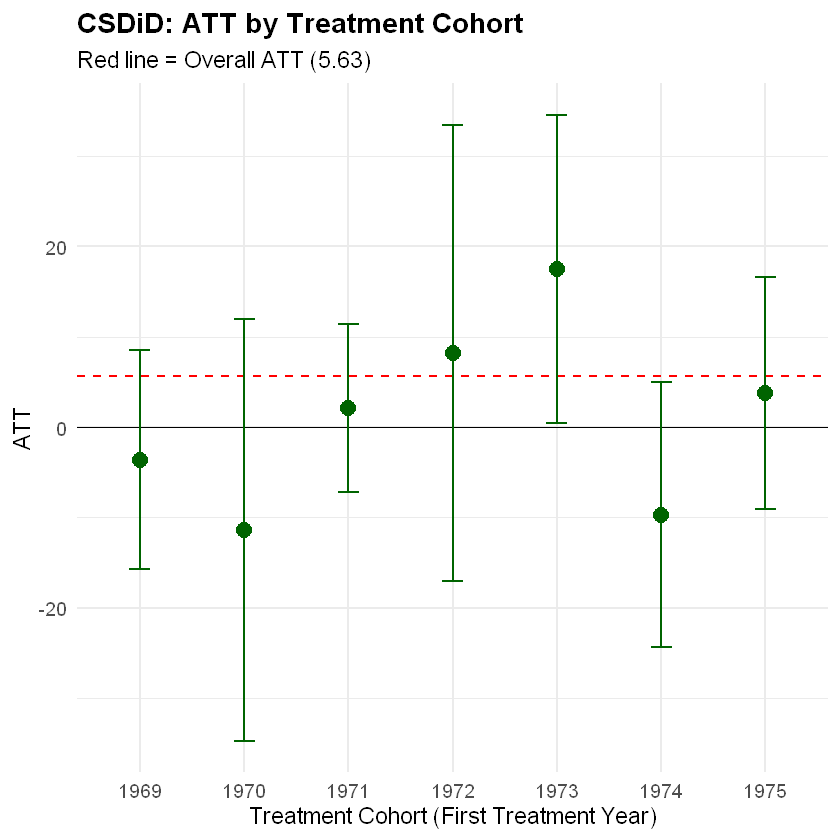

In [13]:
# Plot: Group Aggregation
p_group <- ggplot(group_df, aes(x = factor(group), y = att)) +
  geom_hline(yintercept = 0, color = "black", linewidth = 0.5) +
  geom_hline(yintercept = agg_group$overall.att, color = "red", linetype = "dashed") +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), width = 0.2, color = "darkgreen") +
  geom_point(color = "darkgreen", size = 4) +
  labs(title = "CSDiD: ATT by Treatment Cohort",
       subtitle = paste0("Red line = Overall ATT (", round(agg_group$overall.att, 2), ")"),
       x = "Treatment Cohort (First Treatment Year)", y = "ATT") +
  theme(plot.title = element_text(face = "bold"))

print(p_group)
ggsave("../output/csdid_group_agg.png", p_group, width = 10, height = 6, dpi = 300)

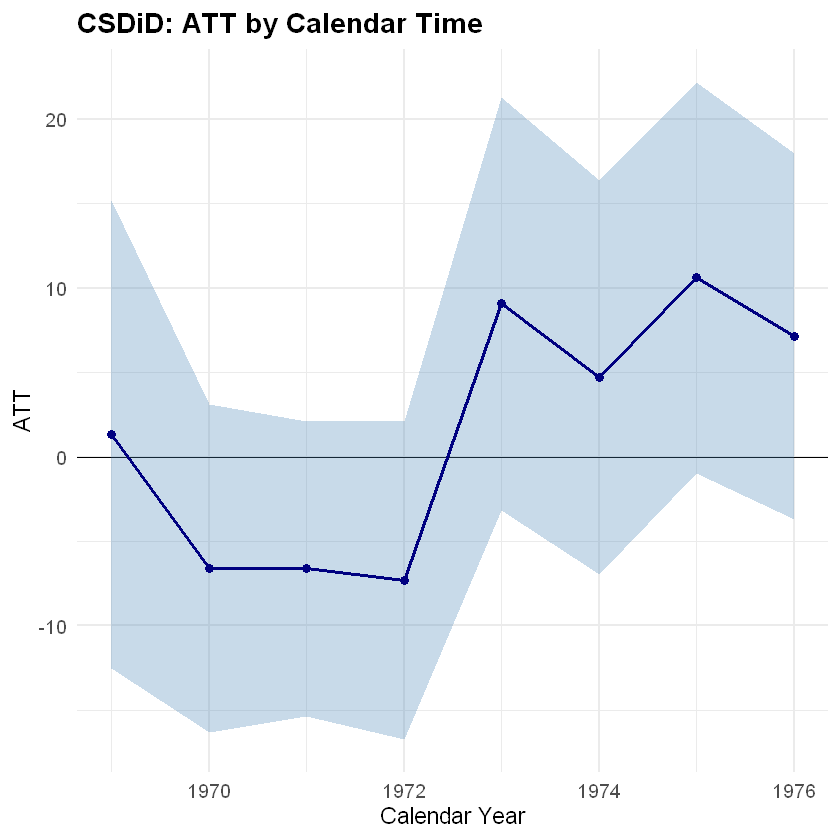

In [14]:
# Plot: Calendar Time Aggregation
p_calendar <- ggplot(calendar_df, aes(x = year, y = att)) +
  geom_hline(yintercept = 0, color = "black", linewidth = 0.5) +
  geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper), fill = "steelblue", alpha = 0.3) +
  geom_line(color = "navy", linewidth = 1) +
  geom_point(color = "navy", size = 2) +
  labs(title = "CSDiD: ATT by Calendar Time",
       x = "Calendar Year", y = "ATT") +
  theme(plot.title = element_text(face = "bold"))

print(p_calendar)
ggsave("../output/csdid_calendar_agg.png", p_calendar, width = 10, height = 6, dpi = 300)


✓ Gráficos guardados en ../output/


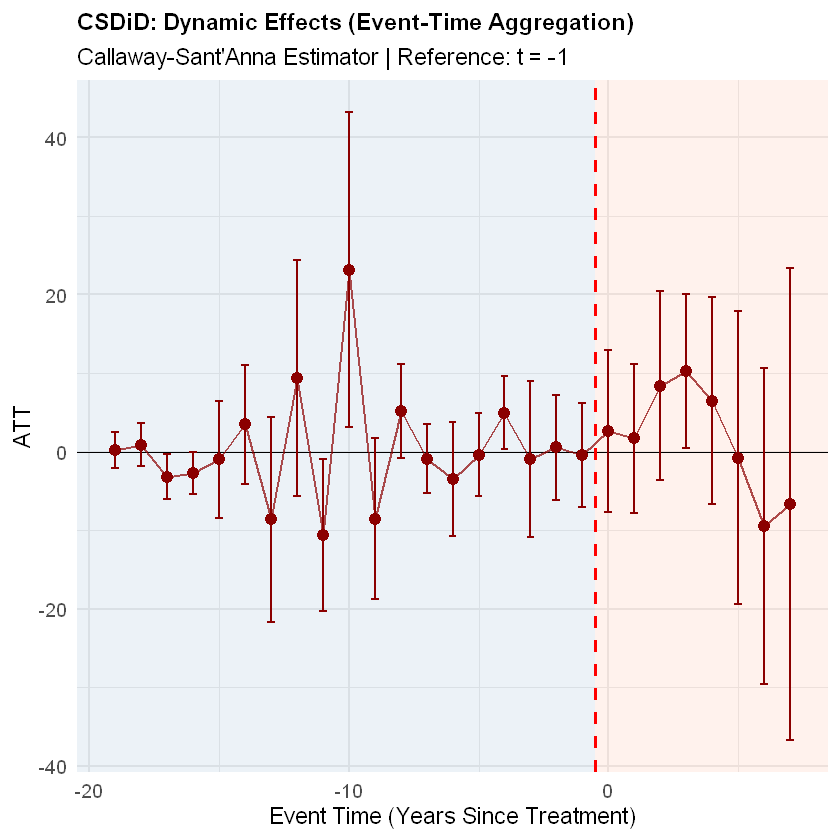

In [15]:
# Plot: Event-Time (Dynamic) Aggregation
p_event <- ggplot(event_df, aes(x = event_time, y = att)) +
  annotate("rect", xmin = -Inf, xmax = -0.5, ymin = -Inf, ymax = Inf, fill = "steelblue", alpha = 0.1) +
  annotate("rect", xmin = -0.5, xmax = Inf, ymin = -Inf, ymax = Inf, fill = "coral", alpha = 0.1) +
  geom_hline(yintercept = 0, color = "black", linewidth = 0.5) +
  geom_vline(xintercept = -0.5, color = "red", linetype = "dashed", linewidth = 1) +
  geom_errorbar(aes(ymin = ci_lower, ymax = ci_upper), width = 0.3, color = "darkred") +
  geom_line(color = "darkred", alpha = 0.7, linewidth = 0.8) +
  geom_point(color = "darkred", size = 3) +
  labs(title = "CSDiD: Dynamic Effects (Event-Time Aggregation)",
       subtitle = "Callaway-Sant'Anna Estimator | Reference: t = -1",
       x = "Event Time (Years Since Treatment)", y = "ATT") +
  theme(plot.title = element_text(face = "bold", size = 14))

print(p_event)
ggsave("../output/csdid_event_study.png", p_event, width = 12, height = 7, dpi = 300)
cat("\n✓ Gráficos guardados en ../output/\n")

---

## Part c) Explanation of Aggregations

### c.1) Aggregation by Group

**Meaning:** The group-specific ATT gives the **average treatment effect for each treatment cohort**, averaged across all post-treatment periods for that cohort.

**Question answered:** "Did treatment have different effects on early vs. late adopters?"

---

### c.2) Aggregation by Period (Calendar Time)

**Meaning:** The calendar-time ATT gives the **average treatment effect at each calendar year**, weighted across all cohorts that were treated by that year.

**Question answered:** "What was the overall treatment effect on treated units in year $t$?"

---

### c.3) Aggregation by Event-Time

**Meaning:** The event-time ATT gives the **average treatment effect at $e$ periods after treatment**, averaged across cohorts.

**Question answered:** "What is the effect of treatment $e$ years after adoption?"

**Why Event-Time is Most Comparable to TWFE Event-Study?**

The event-time aggregation from CSDiD is most comparable to TWFE event-study coefficients because both measure effects at specific **periods relative to treatment** and allow visualization of **pre-trends** and **dynamic effects**.

---

## Part d) Compare CSDiD and TWFE Event-Study

### d.1) Load TWFE Event-Study Results from Q1

In [16]:
# Load TWFE event-study results from Q1
twfe_file <- "../output/event_study_coefficients.csv"

if (file.exists(twfe_file)) {
  twfe_es <- read.csv(twfe_file)
  cat("TWFE Event-Study results loaded successfully!\n")
  print(head(twfe_es, 10))
} else {
  cat("Warning: TWFE results not found at", twfe_file, "\n")
  cat("Please ensure you have run the Q1 notebook first.\n")
  twfe_es <- NULL
}

Please ensure you have run the Q1 notebook first.


### d.2) Comparison Table

In [17]:
# Create comparison table
if (!is.null(twfe_es)) {
  # Prepare CSDiD data
  csdid_compare <- event_df %>%
    select(event_time, att, se) %>%
    rename(CSDiD_ATT = att, CSDiD_SE = se)
  
  # Prepare TWFE data
  twfe_compare <- twfe_es %>%
    select(event_time, coefficient, std_error) %>%
    rename(TWFE_Coef = coefficient, TWFE_SE = std_error)
  
  # Merge
  comparison_df <- full_join(csdid_compare, twfe_compare, by = "event_time") %>%
    arrange(event_time) %>%
    mutate(Difference = CSDiD_ATT - TWFE_Coef)
  
  cat("========================================================================\n")
  cat("COMPARISON TABLE: CSDiD vs TWFE EVENT-STUDY\n")
  cat("========================================================================\n")
  print(comparison_df)
  
  write.csv(comparison_df, "../output/comparison_csdid_twfe.csv", row.names = FALSE)
  cat("\n✓ Comparison table saved to: ../output/comparison_csdid_twfe.csv\n")
} else {
  cat("Cannot create comparison - TWFE results not available.\n")
}

Cannot create comparison - TWFE results not available.


### d.3) Combined Plot

In [18]:
# Create combined comparison plot
if (!is.null(twfe_es)) {
  # Prepare data for plotting
  plot_data <- bind_rows(
    event_df %>%
      mutate(Method = "CSDiD") %>%
      select(event_time, estimate = att, ci_lower, ci_upper, Method),
    twfe_es %>%
      mutate(
        Method = "TWFE",
        estimate = coefficient,
        ci_lower = coefficient - 1.96 * std_error,
        ci_upper = coefficient + 1.96 * std_error
      ) %>%
      select(event_time, estimate, ci_lower, ci_upper, Method)
  )
  
  comparison_plot <- ggplot(plot_data, aes(x = event_time, y = estimate, color = Method)) +
    geom_hline(yintercept = 0, color = "black", linewidth = 0.5) +
    geom_vline(xintercept = -0.5, color = "gray50", linetype = "dashed", linewidth = 1) +
    geom_ribbon(aes(ymin = ci_lower, ymax = ci_upper, fill = Method), alpha = 0.2, color = NA) +
    geom_line(linewidth = 1) +
    geom_point(size = 3, position = position_dodge(width = 0.3)) +
    scale_color_manual(values = c("CSDiD" = "darkred", "TWFE" = "navy")) +
    scale_fill_manual(values = c("CSDiD" = "darkred", "TWFE" = "navy")) +
    labs(
      title = "Comparison: CSDiD Event-Time ATT vs TWFE Event-Study",
      subtitle = "95% Confidence Intervals",
      x = "Event Time (Years Since Treatment)",
      y = "Estimated Effect",
      color = "Method", fill = "Method"
    ) +
    theme(
      plot.title = element_text(face = "bold", size = 14),
      legend.position = "bottom"
    )
  
  print(comparison_plot)
  ggsave("../output/comparison_plot_csdid_twfe.png", comparison_plot, width = 12, height = 7, dpi = 300)
  cat("\n✓ Comparison plot saved to: ../output/comparison_plot_csdid_twfe.png\n")
}

---

## Summary

### Key Results

| Aggregation | Description |
|-------------|-------------|
| **Simple** | Overall treatment effect across all groups and periods |
| **Group** | Effects by treatment cohort (year first treated) |
| **Calendar** | Effects by calendar year |
| **Event-Time** | Dynamic effects by time relative to treatment |

### Output Files Generated

- `att_gt_results.csv` — Raw ATT(g,t) estimates
- `group_aggregation.csv` — Group-level aggregated ATTs
- `calendar_aggregation.csv` — Calendar-time aggregated ATTs
- `csdid_event_time.csv` — Event-time aggregated ATTs
- `comparison_csdid_twfe.csv` — Comparison with TWFE estimates
- `csdid_event_study.png` — Event-study plot
- `comparison_plot_csdid_twfe.png` — Comparison visualization